In [1]:
pip install git+https://github.com/LucianoPereiraValenzuela/ECC_2025_testing.git

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from qiskit import QuantumCircuit
from qiskit.circuit import random_circuit
from qiskit.quantum_info import SparsePauliOp
from ECC2025.testing import test_5a, test_5b, test_5c

Los computadores cuánticos han mejorado mucho los últimos años, siendo capaces de ejecutar algoritmos cuánticos en número de qubits moderados. Sin embargo, no es posible resolver problemas practicos con ellos debido a que son ruidosos.

Para reducir el impacto de estos errores se han propuestos varios metodos de mitigación de errores, siendo el más conocido __Zero-Noise Extrapolation (ZNE)__. Consideremos que queremos evaluar un observable $A$ sobre un estado $|\psi\rangle=U_mU_{m-1}\cdots U_1|0\rangle$, donde $\{U_j\}$ es una secuencia de puertas cuánticas ruidosas. Llamaremos $U=U_mU_{m-1}\cdots U_1$ a la operación del circuito completo. ZNE se basa en obtener varias estimaciones de $\langle A \rangle$ con distintos ruidos realizando "pliegues" de las unitaria $U$:

![](https://github.com/LucianoPereiraValenzuela/ECC_2025_testing/blob/main/img/ECC25_ZNE.png?raw=true)

Estos circuitos son todos equivalente para estimar $A$ gracias a que las puertas cuánticas satisfacen $U^\dagger U=I$. Introducir un $U^\dagger U$ en el circuito es un pliegue.

__Desafio:__ Escriba una función que tenga por input un circuito cuántico ```qc_U``` con la operación $U$ de un número arbitario de qubits, y que construya el circuito equivalente ```qc_U_N``` con $N$ pliegues.

In [3]:
def folding( qc_U, N ):

    qc_U_N = qc_U.copy()

    ##### Escriba su solución acá #####

    ########################
    
    return qc_U_N

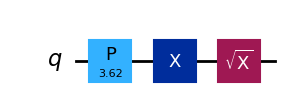

In [4]:
qc_U = random_circuit(1,3)
qc_U.draw('mpl')

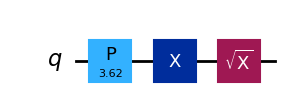

In [5]:
N = 2
qc_U_N = folding( qc_U, N )
qc_U_N.draw('mpl') 

In [6]:
test_5a( folding )

Su solución está equivocada, intenta de nuevo


Debido a que al plegar un circuito si profundidad aumenta, la cantidad de error que sufre tambien aumenta. 

__Desafio:__ Consideremos el siguiente observable de 2 qubits,
$$ A = \sigma_x\otimes \sigma_y + 2\sigma_y\otimes\sigma_x + 3\sigma_z\otimes\sigma_x. $$
Construya este observable utlizando la función ``SparsePauliOp``.

In [15]:
A = SparsePauliOp(['II'], [1])

### Escriba su respuesta aca

A = SparsePauliOp(['XY','YX','ZX'], [1,2,3])

####

A

SparsePauliOp(['XY', 'YX', 'ZX'],
              coeffs=[1.+0.j, 2.+0.j, 3.+0.j])

In [16]:
test_5b( A )

Felicitaciones, tu solución es correcta!


Las siguientes celdas realizan  una simulación con ruido de la evaluación de $A$. El gráfico muestra el resultado para un caso donde $\langle A \rangle = -3$. Podemos como el valor esperado de la simulación ruidosa se va alejando del valor ideal a medida que aumentan los pliegues.

In [9]:
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_aer.primitives import Estimator

noise_model = NoiseModel()
error = depolarizing_error( 0.01, 1 )
noise_model.add_quantum_error( error, ['x', 'h', 'u', 'y', 'z'], [0] )
noise_model.add_quantum_error( error, ['x', 'h', 'u', 'y', 'z'], [1] )

backend = Estimator( backend_options={'noise_model':noise_model},
                    run_options={'shots':1000, 'seed':0 },
                    skip_transpilation = True ) 

In [10]:
def simulacion( qc_U, Ns ):
    obs = []
    for n in Ns:
        qc_U_N = folding( qc_U, n )
        job = backend.run( qc_U_N.decompose(reps=3), A )
        obs.append( job.result().values[0] )
    return obs 

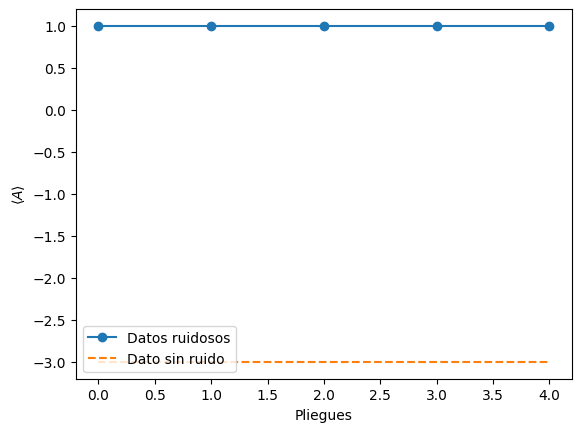

In [11]:
qc_U = QuantumCircuit(2)
qc_U.h(0)
qc_U.cx(0,1)
qc_U.sdg(1)
Ns = [ 0, 1, 2, 3, 4 ]
obs = np.mean([ simulacion( qc_U, Ns ) for _ in range(10) ], axis=0)
plt.plot( Ns, obs, '-o' ) 
plt.hlines( -3, 0, 4, linestyles='--', color='tab:orange' )
plt.xlabel('Pliegues')
plt.ylabel(r'$\langle A \rangle$')
plt.legend(['Datos ruidosos', 'Dato sin ruido'])

Gracias a esto se puede realizar un extrapolación y obtener un estimador de $\langle A\rangle$ "sin ruido". La extrapolación más simple es la lineal, la cual toma estimadores ruidosos $\{ \langle A_N\rangle \}$ de circuitos con $N$ pliegues y supone que
$$ \langle A_N\rangle \approx a ( 2N+1) + b .$$ 
Luego, mediente interpolación por minimos cuadrados se encuentran los parametros $a$ y $b$. El estimador sin ruido es dado por
$$ \langle A\rangle \approx b .$$

( figura )

__Desafio:__ Complete la siguiente función que realiza el ajuste de los parametros $a$ y $b$. Puede ayudarse de funciones de otras librerias como ``numpy`` o ``scipy``.  

In [12]:
def extrapolation( Ns, obs ):

    a = 0
    b = 0

    #### Escriba su solución aca ######
    
    ####################################

    return a, b

Con la siguiente celda podemos ver como funciona nuestra estrapolación.

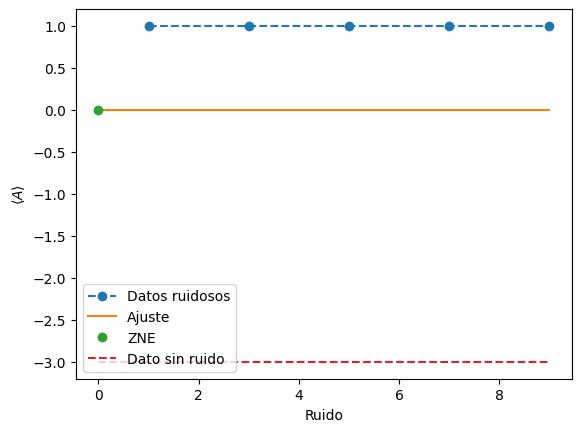

In [13]:
a, b = extrapolation( Ns, obs )
x = np.arange(0,np.max(2*np.array(Ns)+1)+1)
y = a * x + b 
plt.plot( 2*np.array(Ns)+1, obs, '--o' ) 
plt.plot( x, y )
plt.plot( [0], [b], 'o' )
plt.hlines( -3, 0, 9, linestyles='--', color='tab:red' )
plt.xlabel('Ruido')
plt.ylabel(r'$\langle A\rangle$')
plt.legend(['Datos ruidosos', 'Ajuste', 'ZNE','Dato sin ruido' ] )

In [14]:
test_5c( extrapolation, A, Ns, folding )

Su solución está equivocada, intenta de nuevo.


C:\Users\lucia\AppData\Local\Temp\ipykernel_26284\3065500592.py:1: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  test_5c( extrapolation, A, Ns, folding )
C:\Users\lucia\AppData\Local\Temp\ipykernel_26284\3065500592.py:1: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  test_5c( extrapolation, A, Ns, folding )
